In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import glob
from scipy.stats import binned_statistic, mode

In [2]:
dbfiles = glob.glob('*10yrs.db')
dbfiles.sort()

In [3]:
dbfiles

['baseline_nexp2_v1.7_10yrs.db',
 'rolling_nm_scale0.2_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale0.2_nslice3_v1.7_10yrs.db',
 'rolling_nm_scale0.4_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale0.4_nslice3_v1.7_10yrs.db',
 'rolling_nm_scale0.6_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale0.6_nslice3_v1.7_10yrs.db',
 'rolling_nm_scale0.8_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale0.8_nslice3_v1.7_10yrs.db',
 'rolling_nm_scale0.9_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale0.9_nslice3_v1.7_10yrs.db',
 'rolling_nm_scale1.0_nslice2_v1.7_10yrs.db',
 'rolling_nm_scale1.0_nslice3_v1.7_10yrs.db']

In [4]:
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

ra = 0
dec = -20.

f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
        'i': 'cyan', 'z': 'orange', 'y': 'red'}



In [5]:
def mymode(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

In [6]:
def gap_stats(inarr, bins):
    inarr = np.sort(inarr)
    
    count, _b1, _b2 = binned_statistic(inarr, inarr, bins=bins, statistic=np.size)
    unight = np.unique(inarr)
    di = np.diff(unight)
    good = np.where(di < 50.)[0]
    
    me, _b1, _b2 = binned_statistic(unight[1:][good], di[good], bins=bins, statistic=np.mean)
    med, _b1, _b2 = binned_statistic(unight[1:][good], di[good], bins=bins, statistic=np.median)
    nm, _b1, _b2 = binned_statistic(unight[1:][good], di[good], bins=bins, statistic=mymode)
    
    
    return count, me, med, nm

Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 1570382 visits
Running:  ['baseline_nexp2_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 1564754 visits
Running:  ['rolling_nm_scale0_2_nslice2_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']


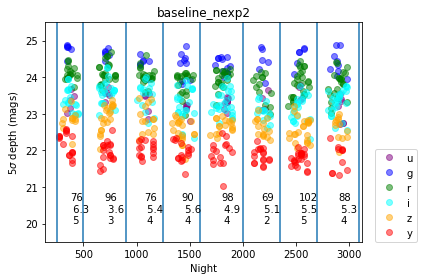

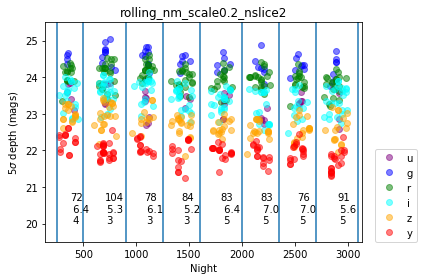

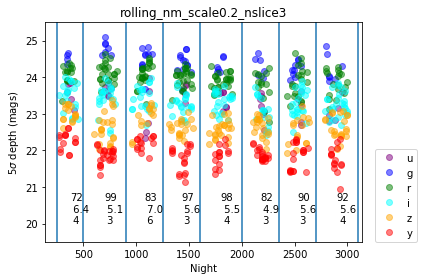

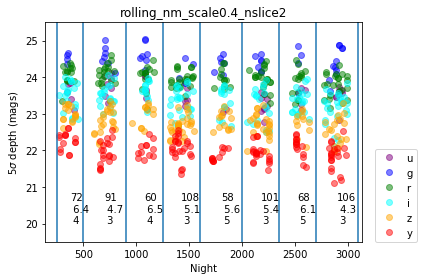

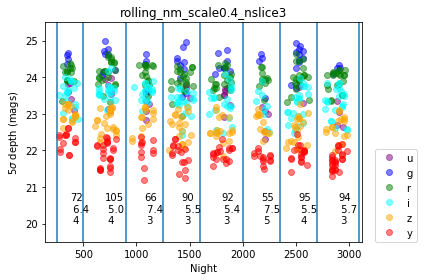

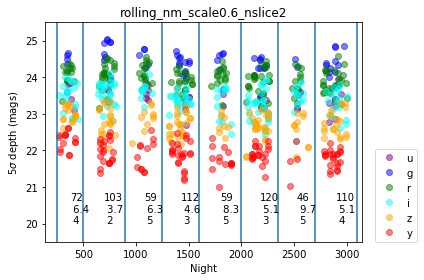

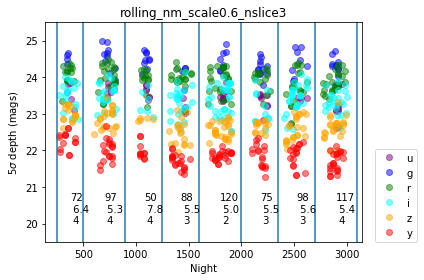

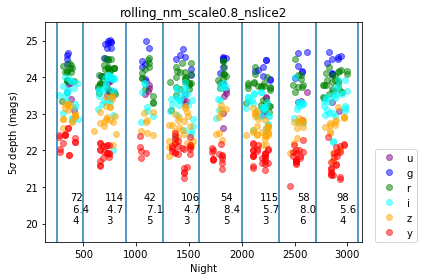

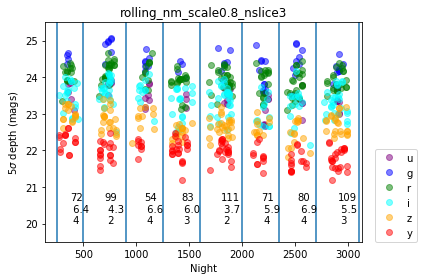

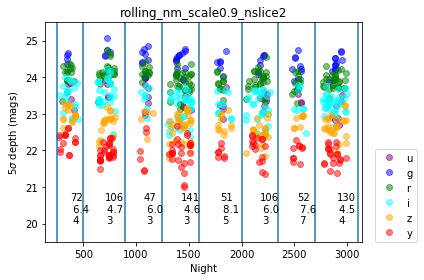

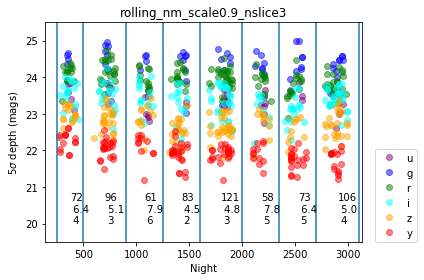

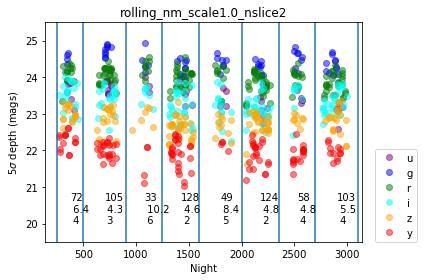

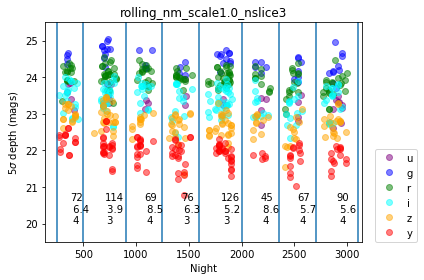

In [7]:
for filename in dbfiles:

    name = filename.replace('_v1.7_10yrs.db', '')

    conn = db.OpsimDatabase(filename)
    bundleList = []
    sql = 'night > 250 and night < %i' %(365*8.5)
    metric = metrics.PassMetric(['filter', 'observationStartMJD', 'fiveSigmaDepth', 'night'])
    slicer = slicers.UserPointsSlicer(ra=ra, dec=dec)
    summaryStats = []
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=name))
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    #bg.plotAll(closefigs=False)

    mv = bundleList[0].metricValues[0]
    plt.figure()
    for fn in f2c:
        in_filt = np.where(mv['filter'] == fn)[0]
        plt.plot(mv['night'][in_filt],
                 mv['fiveSigmaDepth'][in_filt], 'o',
                 color=f2c[fn], label=fn, alpha=0.5)
    plt.xlabel('Night')
    plt.ylabel(r'5$\sigma$ depth (mags)')
    plt.legend(loc=(1.04,0))

    breaks = np.array([250, 500, 900, 1250, 1600, 2000, 2350, 2700, 3100])
    for br in breaks:
        plt.axvline(br)

    di = np.diff(breaks)
    mps = breaks[0:-1] + di/2
    counts, mean_gaps, med_gaps, mode_gaps = gap_stats(mv['night'], bins=breaks)

    for i in np.arange(mps.size):
        plt.annotate('%i\n %.1f \n %i' % (counts[i], mean_gaps[i], med_gaps[i]), [mps[i], 20])

    plt.ylim([19.5, 25.5])
    #plt.xlim([1340, 1560])
    plt.title(name)
    plt.tight_layout()
    #plt.savefig('ddf_plots/ddf_m5_%s.pdf' % name, type='pdf')
